In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from transformers import AutoTokenizer, AutoModel

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
np.random.seed(0)

# Models

In [6]:
text_model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(text_model_name)
text_model = AutoModel.from_pretrained(text_model_name).eval().to(device)

def embed_bert_cls(text):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = text_model(**{k: v.to(text_model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    return embeddings


class Hyperparameters(object):
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)


hp = Hyperparameters(latent_dim=100,
                     text_emb_size=text_model.config.hidden_size,
                     img_size=64,
                     channels=3,
                     ngf=64,
                     ndf=64,
                     n_sampled_examples=18,
                     sampled_grid_shape=(3, 6)
                    )

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
fixed_noise = torch.randn((hp.n_sampled_examples, hp.latent_dim, 1, 1)).to(device)

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
def to_img(x):
    x = x.clamp(0, 1)
    return x

def visualise_output(images, texts, x, y, save_path=None):
    with torch.no_grad():
        images = images.cpu()
        images = to_img(images)
        fig, axes = plt.subplots(x, y, figsize=(20, 16))
        item_idx = 0
        for i in range(x):
            for j in range(y):
                splitted_text = texts[item_idx].split()
                cur_text = [" ".join(splitted_text[x:x + 2]) for x in range(0, len(splitted_text), 2)]
                axes[i][j].imshow(np.transpose(images[item_idx], (1, 2, 0)))
                axes[i][j].set_title("\n".join(cur_text))
                axes[i][j].axis("off")
                item_idx += 1
                if item_idx >= len(texts):
                    break
                
            if item_idx >= len(texts):
                break
        
        plt.subplots_adjust(hspace=-0.1, wspace=0.15)
        if save_path is not None:
            fig.savefig(save_path, dpi=fig.dpi)
        plt.show()

In [12]:
# Conditional DCGAN
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.text_layer = nn.Sequential(
            nn.ConvTranspose2d(hp.text_emb_size, hp.ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hp.ngf * 4),
            nn.ReLU(True)
            # state size. ``(ngf*4) x 4 x 4``
        )
        self.noise_layer = nn.Sequential(
            nn.ConvTranspose2d(hp.latent_dim, hp.ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hp.ngf * 4),
            nn.ReLU(True)
            # state size. ``(ngf*4) x 4 x 4``
        )
        self.model = nn.Sequential(
            nn.ConvTranspose2d(hp.ngf * 8, hp.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hp.ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d(hp.ngf * 4, hp.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hp.ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d(hp.ngf * 2, hp.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hp.ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d(hp.ngf, hp.channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, noise, text_emb):
        noise_out = self.noise_layer(noise)
        text_out = self.text_layer(text_emb)
        gen_input = torch.cat([text_out, noise_out], 1)
        img = self.model(gen_input)
        return img

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Load pretrained model

In [13]:
checkpoint_path = "saved_models/conditional_dcgan_20240521_155941/generator_70.pth"
generator = Generator().apply(weights_init)
generator.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
generator.to(device);

### Типы одежды:
```
'Тапочки', 'Сумки', 'Шапка/шапочка', 'Резинка для волос', 'Пижамный комплект', 'Блейзер', 'Шляпы', 'Блузка', 'Шарф', 'Носки', 'Футболка', 'Брюки уличные', 'Свитер', 'Ремень', 'Поло', 'Кольцо', 'Штаны', 'Пальто', 'Перчатки', 'Толстовка с капюшоном', 'Топ', 'Кроссовки', 'Боди', 'Нижняя часть купальника', 'Нижнее белье, низ', 'Верх жилета', 'Колпачок', 'Серьга', 'Куртка', 'Ночное платье', 'Нижнее белье', 'Платье', 'Аксессуары', 'Топ-бикини', 'Пижама, низ', 'Пижамный комбинезон/костюм для подвижных игр', 'Шорты', 'Нижнее белье, колготки', 'Сандалии', 'Бра', 'Комплект купальников', 'Кардиган', 'Купальник', 'Солнцезащитные очки', 'Браслет', 'Зажим для волос', 'Комплект одежды', 'Рубашки', 'Обувь', 'Леггинсы/колготки', 'Юбка', 'Ботинки', 'Ожерелье', 'Комбинезон/костюм для подвижных игр'

```

### Типы эмоций / настроений / ассоциаций:
```
'Процветание', 'Простота', 'Военщина', 'Богатство', 'Практичность', 'Энергия', 'Элегантность', 'Мистика', 'Опасность', 'Власть', 'Роскошь', 'Природа', 'Консерватизм', 'Нежность', 'Уныние', 'Тайна', 'Тепло', 'Защита', 'Изысканность', 'Чистота', 'Страсть', 'Возбуждение', 'Ностальгия', 'Зло', 'Стабильность', 'Энтузиазм', 'Отчужденность', 'Невинность', 'Женственность', 'Современность', 'Формальность', 'Надежность', 'Сила', 'Спокойствие', 'Любовь', 'Страх', 'Печаль', 'Свежесть', 'Наивность', 'Успех', 'Мудрость', 'Мечтательность', 'Гнев', 'Ясность', 'Радость', 'Духовность', 'Маскулинность', 'Жизнь', 'Умиротворение', 'Обновление', 'Агрессия', 'Драматизм', 'Движение', 'Творчество', 'Целостность', 'Холодность', 'Уверенность', 'Стерильность', 'Нейтральность', 'Доверие', 'Сладость', 'Гармония', 'Уравновешенность', 'Гламур', 'Амбициозность', 'Депрессия', 'Солнце', 'Романтика'
```

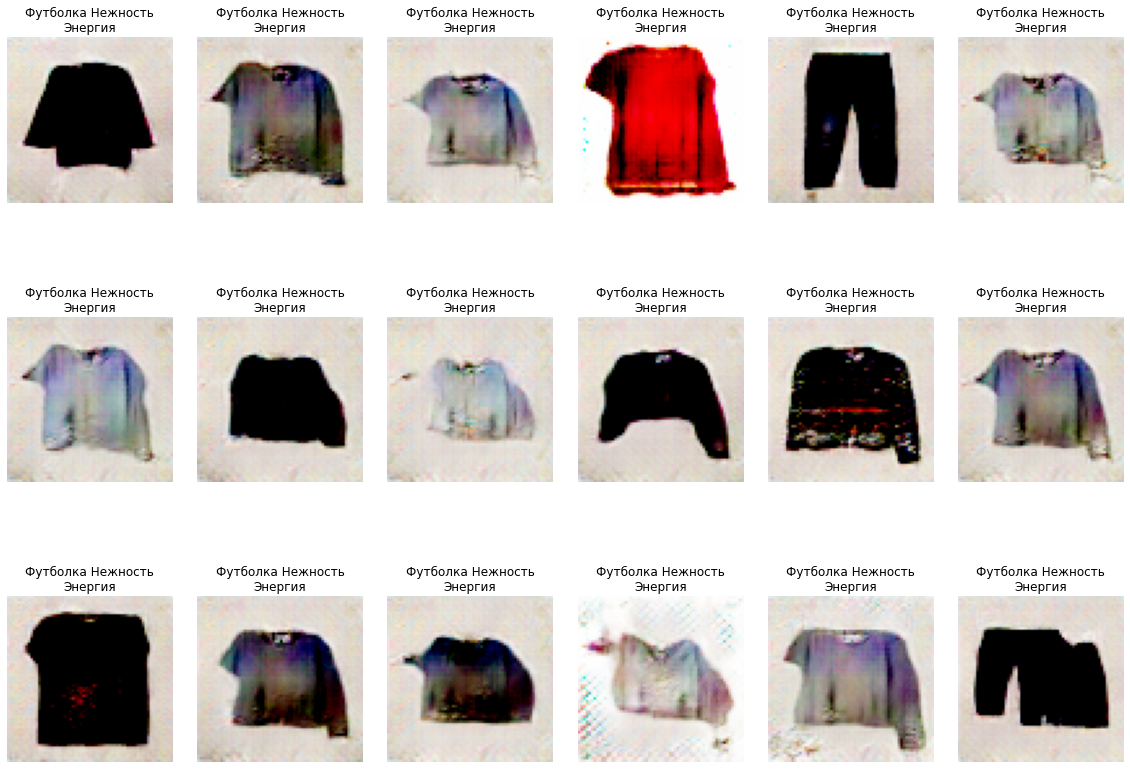

In [23]:
text_input = "Футболка Нежность Энергия"

labels = embed_bert_cls(text_input).to(device)[..., None, None]
labels = torch.repeat_interleave(labels, hp.n_sampled_examples, 0)
gen_imgs = generator(fixed_noise, labels)

visualise_output(gen_imgs, [text_input] * hp.n_sampled_examples, 
                 hp.sampled_grid_shape[0], hp.sampled_grid_shape[1])